# Problem Statement

- Classify movies into 3 classes - 'Rotten', 'Fresh' or 'Certified-Fresh'\
- Criteria is as follows:
    - Fresh: Tomatometer score >= 60%
    - Rotten: Tomatometer score < 60%
    - Certified-Fresh: TBD

- We will use 2 approaches:
    1. Predict movie status based on **numerical and categorical features**.
    2. Predict movie status based on **Review Sentiment**

- We will use:
    - Decision Tree Classifier
    - Random Forest Algorithm



# 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df_movie = pd.read_csv('rotten_tomatoes_movies.csv')
df_movie.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [3]:
df_movie.describe() # gives the description of the numerical features

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


- We have a large number of numerical features.
- Our target variable is `tomatometer_status`
- It is important to note that features have missing values, we need to deal with.

Content Rating category: ['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


[Text(0, 0, '6377'),
 Text(0, 0, '5474'),
 Text(0, 0, '2979'),
 Text(0, 0, '2168'),
 Text(0, 0, '676'),
 Text(0, 0, '38')]

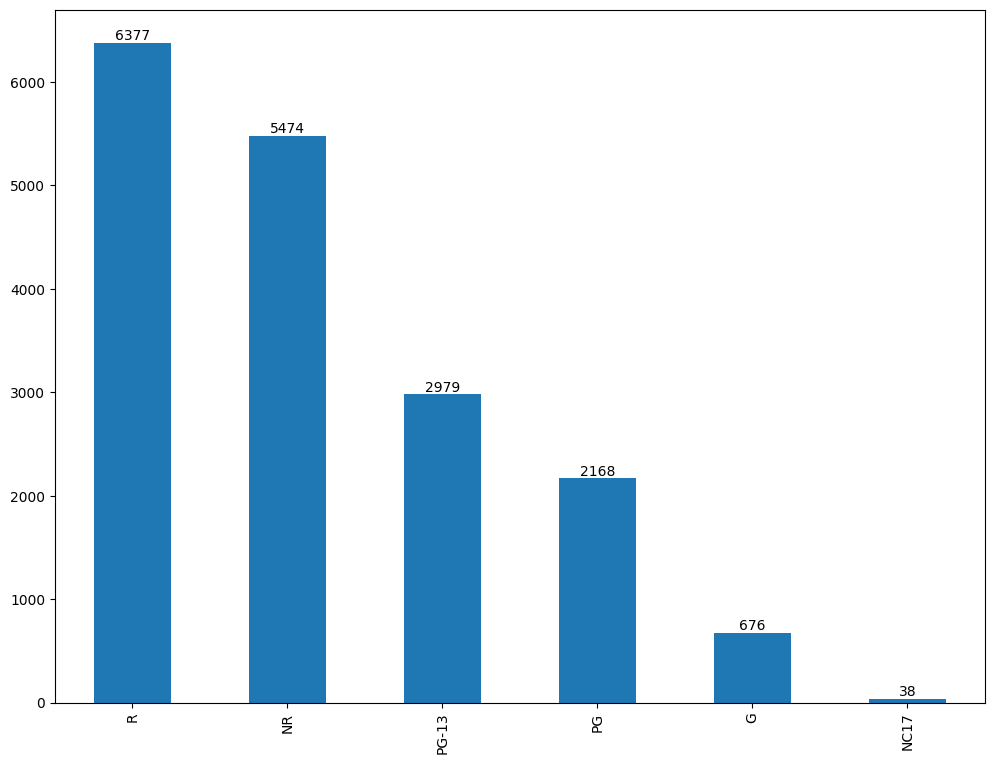

In [4]:
# Visualizing content rating
print(f'Content Rating category: {df_movie.content_rating.unique()}')

ax = df_movie['content_rating'].value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

- Need to convert this feature into numerical representations
- Two popular methods: **ordinal encoding** and **one-hot encoding**
### Ordinal Encoding
It is used when the categorical feature represents a degree of magnitude (think S, M, L).
### One Hot Encoding
It is used when one value is not more important than other values in a categorical feature.

In [5]:
# one-hot encoding the content rating feature
content_rating = pd.get_dummies(df_movie['content_rating'])
content_rating.head()

,G,NC17,NR,PG,PG-13,R
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,1,0,0,0
4,1,0,0,0,0,0


- Audience Status has the values 'Spilled' and 'Upright'.
- It needs ordinal encoding.

Audience Status Category: ['Spilled' 'Upright' nan]


[Text(0, 0, '9390'), Text(0, 0, '7874')]

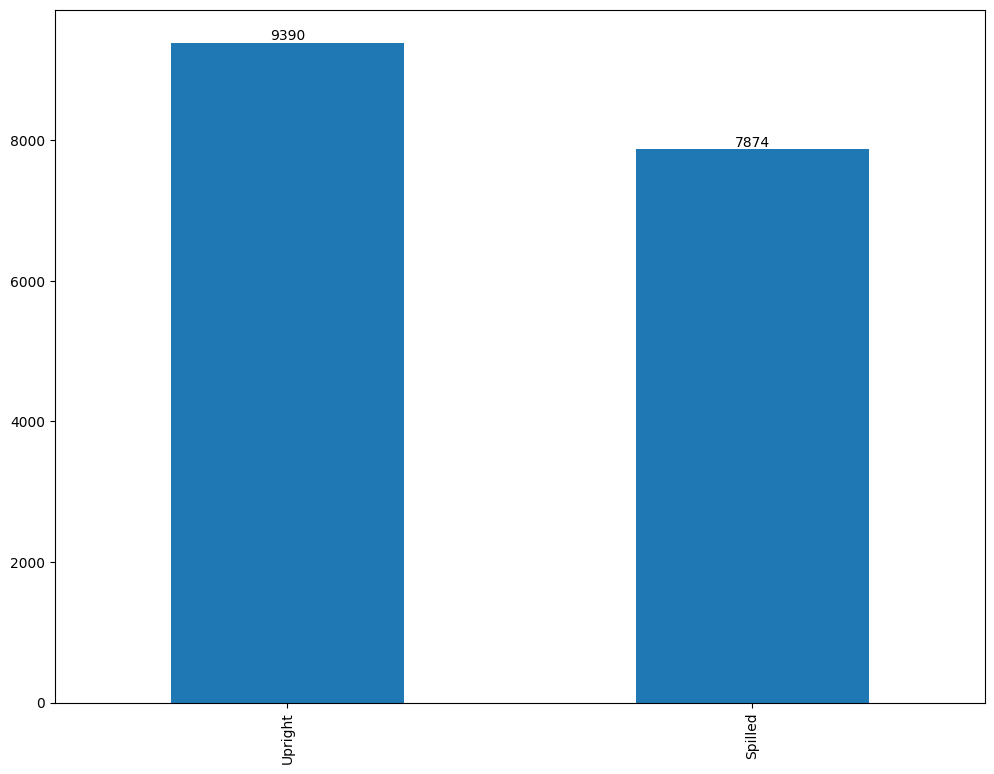

In [6]:
print(f'Audience Status Category: {df_movie.audience_status.unique()}')

ax = df_movie.audience_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [7]:
# ordinal coding for audience status
audience_status = pd.DataFrame(df_movie.audience_status.replace(['Spilled', 'Upright'], [0,1]))
audience_status.head()

,audience_status
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


**Note: You can use the `.replace()` method in pandas DataFrame to encode categorical values of a feature into numerical values**

In [8]:
# Encode tomatometer status with ordinal encoding
tomatometer_status = pd.DataFrame(df_movie.tomatometer_status.replace(['Rotten', 'Fresh', 'Certified-Fresh'], [0,1,2]))
tomatometer_status.head()

,tomatometer_status
0,0.0
1,2.0
2,1.0
3,2.0
4,1.0


In [12]:
# Combine all features into one dataframe. Drop NULL values
df_feature = pd.concat([df_movie[['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', \
    'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']], \
        content_rating, audience_status, tomatometer_status], axis=1).dropna()
df_feature.head()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
0,119.0,49.0,149.0,53.0,254421.0,43,73,76,0,0,0,1,0,0,0.0,0.0
1,90.0,87.0,142.0,64.0,11574.0,44,123,19,0,0,0,0,0,1,1.0,2.0
2,122.0,67.0,24.0,53.0,14684.0,2,16,8,0,0,0,0,0,1,0.0,1.0
3,95.0,100.0,54.0,97.0,105386.0,6,54,0,0,0,1,0,0,0,1.0,2.0
4,127.0,89.0,27.0,74.0,68918.0,5,24,3,1,0,0,0,0,0,1.0,1.0


In [13]:
df_feature.describe().T

,count,mean,std,min,25%,50%,75%,max
runtime,17017.0,102.296233,1.865365e+01,5.0,90.0,99.0,111.0,266.0
tomatometer_rating,17017.0,60.519539,2.843640e+01,0.0,38.0,66.0,86.0,100.0
tomatometer_count,17017.0,57.097197,6.681458e+01,5.0,12.0,29.0,76.0,535.0
audience_rating,17017.0,60.324499,2.048060e+01,0.0,44.0,62.0,77.0,100.0
audience_count,17017.0,147118.274843,1.783955e+06,5.0,741.0,4423.0,26067.0,35797635.0
tomatometer_top_critics_count,17017.0,14.765999,1.517226e+01,0.0,3.0,8.0,23.0,69.0
tomatometer_fresh_critics_count,17017.0,36.237292,5.136245e+01,0.0,6.0,17.0,44.0,497.0
tomatometer_rotten_critics_count,17017.0,20.871188,2.997890e+01,0.0,3.0,8.0,24.0,303.0
G,17017.0,0.039314,1.943458e-01,0.0,0.0,0.0,0.0,1.0
NC17,17017.0,0.002174,4.658000e-02,0.0,0.0,0.0,0.0,1.0


[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

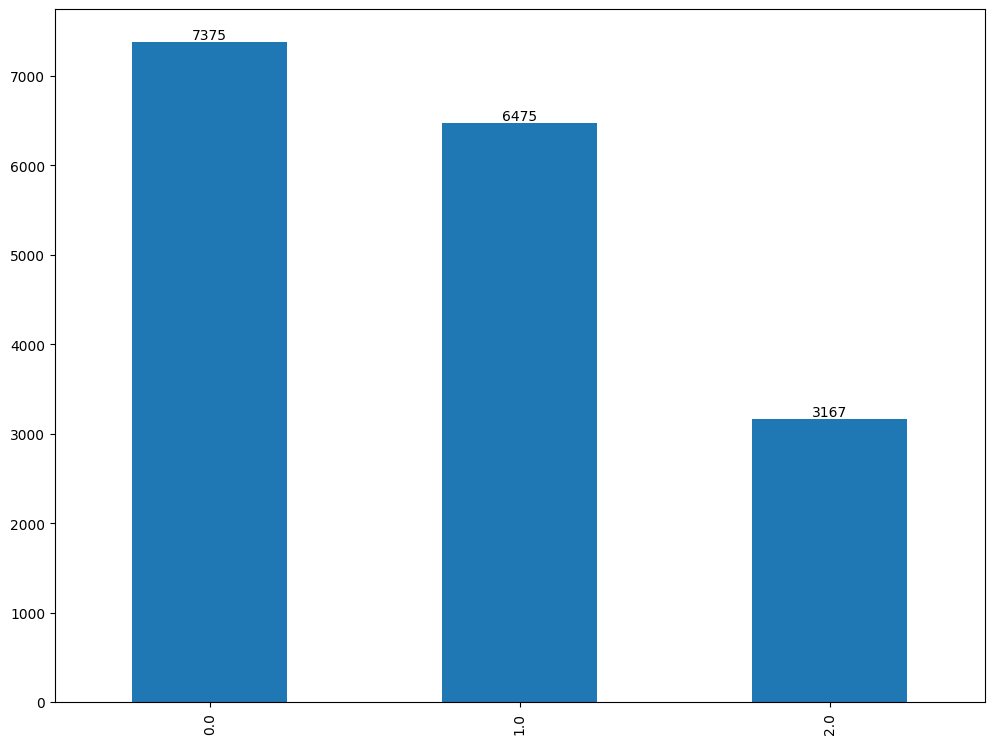

In [15]:
# Get the distribution of the target variable
ax = df_feature.tomatometer_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

We have a class imbalance problem, need to address this later.

- Let us now create train and test splits of the dataset.

In [16]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(['tomatometer_status'], axis=1), \
    df_feature['tomatometer_status'], test_size=0.2, random_state=42)

print(f'Size of training data is {len(X_train)} and the size of the test data is {len(X_test)}')

Size of training data is 13613 and the size of the test data is 3404
